<a href="https://colab.research.google.com/github/gazalpatel/REINFORCE/blob/main/seed_week_3_trials_RL_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 10 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 41.90
Episode 100	Average Reward: 107.22
Episode 150	Average Reward: 182.28
Episode 200	Average Reward: 183.70
Episode 250	Average Reward: 173.50
Episode 300	Average Reward: 199.56

Environment solved in 328 episodes with average reward 195.12 over the last 100 episodes.


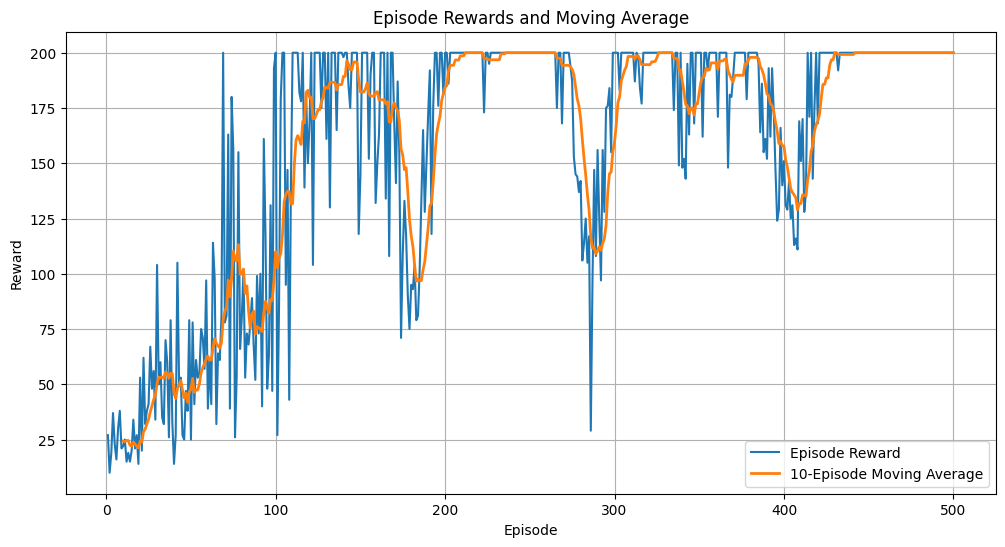

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'episode_rewards' is the list of rewards from training
# Calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot the episode rewards and moving average
plt.figure(figsize=(12,6))
episodes = np.arange(1, len(episode_rewards)+1)
plt.plot(episodes, episode_rewards, label='Episode Reward')

# Choose a window size for moving average (e.g., 10 episodes)
window_size = 10
ma_rewards = moving_average(episode_rewards, window_size)
ma_episodes = episodes[window_size-1:]

plt.plot(ma_episodes, ma_rewards, label=f'{window_size}-Episode Moving Average', linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards and Moving Average')
plt.legend()
plt.grid(True)
plt.show()


## BASELINE

Episode 50	Average Reward: 38.46
Episode 100	Average Reward: 86.20
Episode 150	Average Reward: 173.72
Episode 200	Average Reward: 154.92
Episode 250	Average Reward: 198.08

Environment solved in 275 episodes with average reward 195.18 over the last 100 episodes.


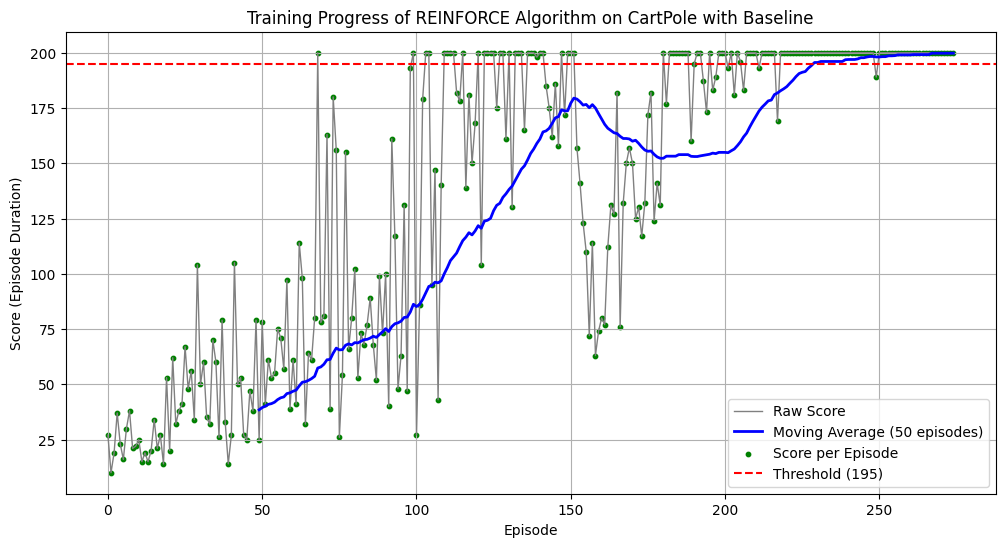

In [8]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Compute the baseline (mean of returns)
    baseline = returns.mean()
    # Compute advantages by subtracting the baseline
    advantages = returns - baseline
    # Normalize advantages for better convergence
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
    # Compute policy gradient loss using advantages
    loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        loss.append(-log_prob * advantage)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on CartPole with Baseline')
plt.legend()
plt.grid(True)
plt.show()


## LEARNED BASELINE

Episode 50	Average Reward: 31.34
Episode 100	Average Reward: 88.00
Episode 150	Average Reward: 175.78
Episode 200	Average Reward: 137.56
Episode 250	Average Reward: 156.56
Episode 300	Average Reward: 200.00

Environment solved in 316 episodes with average reward 195.70 over the last 100 episodes.


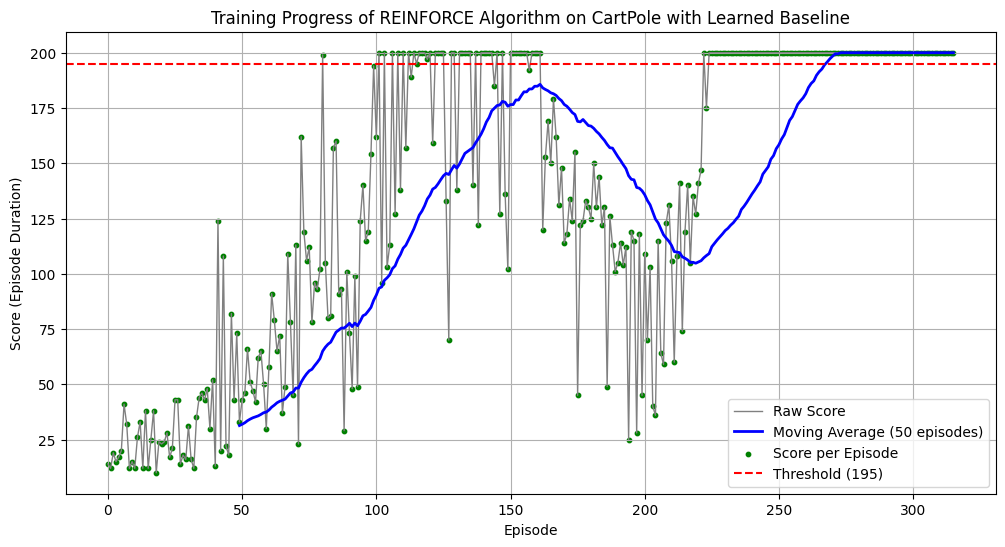

In [10]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Define the value network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        value = self.fc2(x)
        return value.squeeze()

# Instantiate the policy and value networks
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)
value_net = ValueNetwork(state_dim, hidden_size=128)

# Set the optimizers
learning_rate = 0.003
policy_optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []
    state_values = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Get state value from the value network
        value = value_net(state)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward, log probability, and state value
        rewards.append(reward)
        log_probs.append(log_prob)
        state_values.append(value)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Convert state_values to tensor
    state_values = torch.stack(state_values)
    # Compute advantages by subtracting the estimated state values
    advantages = returns - state_values.detach().squeeze()
    # Normalize advantages for better convergence
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
    # Compute policy gradient loss using advantages
    policy_loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        policy_loss.append(-log_prob * advantage)
    policy_loss = torch.stack(policy_loss).sum()
    # Update policy network
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    # Compute value loss (MSE between estimated values and returns)
    value_loss = nn.functional.mse_loss(state_values.squeeze(), returns)
    # Update value network
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on CartPole with Learned Baseline')
plt.legend()
plt.grid(True)
plt.show()


## CUSTOM REWARD

Episode 50	Average Reward: 16.58
Episode 100	Average Reward: 24.26
Episode 150	Average Reward: 100.87
Episode 200	Average Reward: 171.01
Episode 250	Average Reward: 191.47
Episode 300	Average Reward: 178.41
Episode 350	Average Reward: 149.78
Episode 400	Average Reward: 169.31
Episode 450	Average Reward: 185.74
Episode 500	Average Reward: 193.02


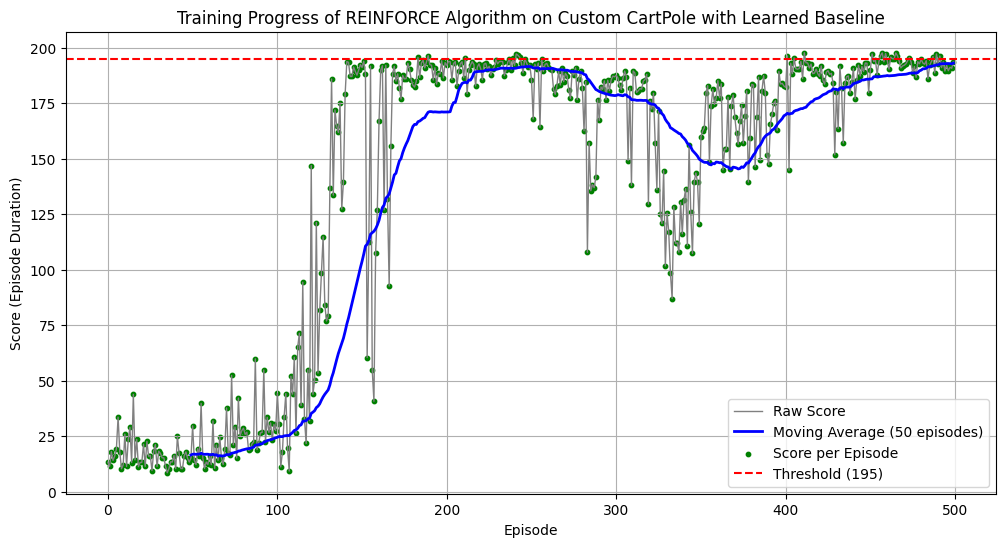

In [15]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym.envs.classic_control.cartpole import CartPoleEnv
from gym.wrappers import TimeLimit

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create a custom environment with modified reward function
class CustomCartPoleEnv(CartPoleEnv):
    def __init__(self):
        super(CustomCartPoleEnv, self).__init__()
        # Seed the environment
        if hasattr(self, 'seed'):
            self.seed(seed)
        else:
            self.np_random, _ = gym.utils.seeding.np_random(seed)

    def step(self, action):
        # Original step function
        result = super(CustomCartPoleEnv, self).step(action)
        # Unpack result based on Gym version
        if len(result) == 4:
            obs, reward, done, info = result
        else:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
        # Modify the reward
        x, x_dot, theta, theta_dot = obs
        # Penalize the cart for being away from center
        reward -= abs(x) * 0.1
        # Penalize the pole angle deviation
        reward -= abs(theta) * 0.5
        return obs, reward, done, info

# Instantiate the custom environment and wrap with TimeLimit
env = CustomCartPoleEnv()
env = TimeLimit(env, max_episode_steps=200)  # Enforce max episode length of 200 steps

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network (same as before)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Define the value network (same as before)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        value = self.fc2(x)
        return value.squeeze()

# Instantiate the policy and value networks
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)
value_net = ValueNetwork(state_dim, hidden_size=128)

# Set the optimizers
learning_rate = 0.003
policy_optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 200  # Ensure consistency with environment's max steps

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        state, _ = reset_result
    else:
        state = reset_result
    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []
    state_values = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Get state value from the value network
        value = value_net(state)
        # Step the environment
        step_result = env.step(action.item())
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
        else:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        next_state = torch.from_numpy(next_state).float()
        # Save reward, log probability, and state value
        rewards.append(reward)
        log_probs.append(log_prob)
        state_values.append(value)
        # Update state
        state = next_state
        if done:
            break
    # If no steps were taken, continue to the next episode
    if not rewards:
        continue
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    # Convert returns to tensor with float32 dtype
    returns = torch.tensor(returns, dtype=torch.float32)
    # Convert state_values to tensor
    state_values = torch.stack(state_values)
    # Compute advantages by subtracting the estimated state values
    advantages = returns - state_values.detach().squeeze()
    # Normalize advantages for better convergence
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
    # Compute policy gradient loss using advantages
    policy_loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        policy_loss.append(-log_prob * advantage)
    policy_loss = torch.stack(policy_loss).sum()
    # Update policy network
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    # Compute value loss (MSE between estimated values and returns)
    value_loss = nn.functional.mse_loss(state_values.squeeze(), returns)
    # Update value network
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100 and len(episode_rewards) >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
if len(score_array) >= window_size:
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on Custom CartPole with Learned Baseline')
plt.legend()
plt.grid(True)
plt.show()


## ENTROPY REGULARIZATION

Episode 50	Average Reward: 28.36
Episode 100	Average Reward: 75.80
Episode 150	Average Reward: 141.92
Episode 200	Average Reward: 190.24
Episode 250	Average Reward: 197.54
Episode 300	Average Reward: 151.70
Episode 350	Average Reward: 158.28
Episode 400	Average Reward: 152.58
Episode 450	Average Reward: 107.60
Episode 500	Average Reward: 115.78


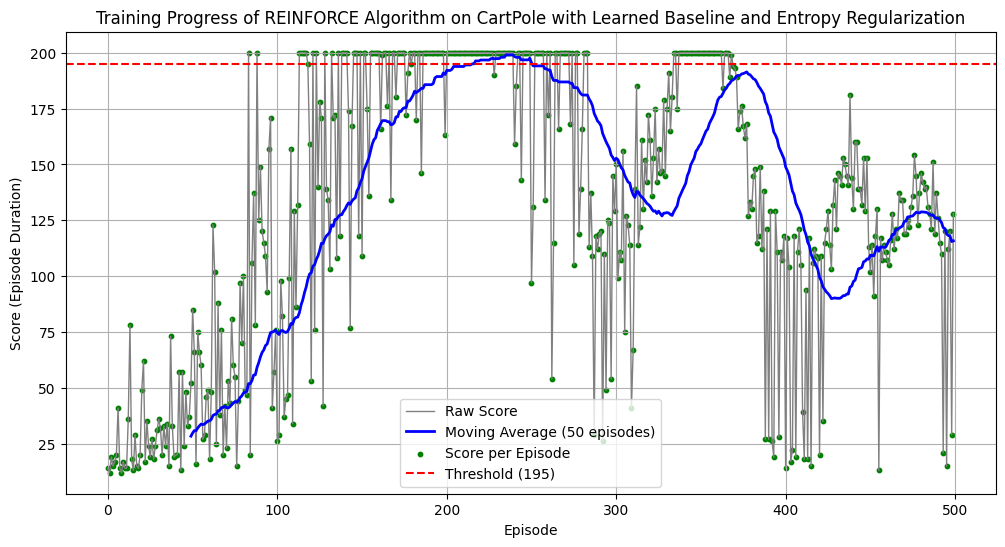

In [16]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        # Note: We'll apply softmax in the forward pass to get probabilities

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)
        probs = torch.softmax(logits, dim=-1)
        return probs

# Define the value network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        value = self.fc2(x)
        return value.squeeze()

# Instantiate the policy and value networks
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)
value_net = ValueNetwork(state_dim, hidden_size=128)

# Set the optimizers
learning_rate = 0.003
policy_optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500
entropy_coef = 0.01  # Entropy regularization coefficient

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []
    state_values = []
    probs_list = []  # To store action probabilities for entropy calculation

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Get state value from the value network
        value = value_net(state)
        # Step the environment
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.from_numpy(next_state).float()
        # Save reward, log probability, state value, and probabilities
        rewards.append(reward)
        log_probs.append(log_prob)
        state_values.append(value)
        probs_list.append(probs)
        # Update state
        state = next_state
        if done:
            break
    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Ensure data types match
    returns = returns.float()
    # Convert state_values to tensor
    state_values = torch.stack(state_values)
    # Compute advantages by subtracting the estimated state values
    advantages = returns - state_values.detach()
    # Normalize advantages for better convergence
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
    # Compute policy gradient loss using advantages and entropy regularization
    policy_loss = []
    for log_prob, advantage, prob in zip(log_probs, advantages, probs_list):
        entropy = -torch.sum(prob * torch.log(prob + 1e-9))
        policy_loss.append(-log_prob * advantage - entropy_coef * entropy)
    policy_loss = torch.stack(policy_loss).sum()
    # Update policy network
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    # Compute value loss (MSE between estimated values and returns)
    value_loss = nn.functional.mse_loss(state_values.squeeze(), returns)
    # Update value network
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on CartPole with Learned Baseline and Entropy Regularization')
plt.legend()
plt.grid(True)
plt.show()


Episode 50	Average Reward: 27.76
Episode 100	Average Reward: 64.40
Episode 150	Average Reward: 152.36
Episode 200	Average Reward: 173.44
Episode 250	Average Reward: 176.32
Episode 300	Average Reward: 168.52
Episode 350	Average Reward: 177.80
Episode 400	Average Reward: 167.92
Episode 450	Average Reward: 168.74
Episode 500	Average Reward: 176.88


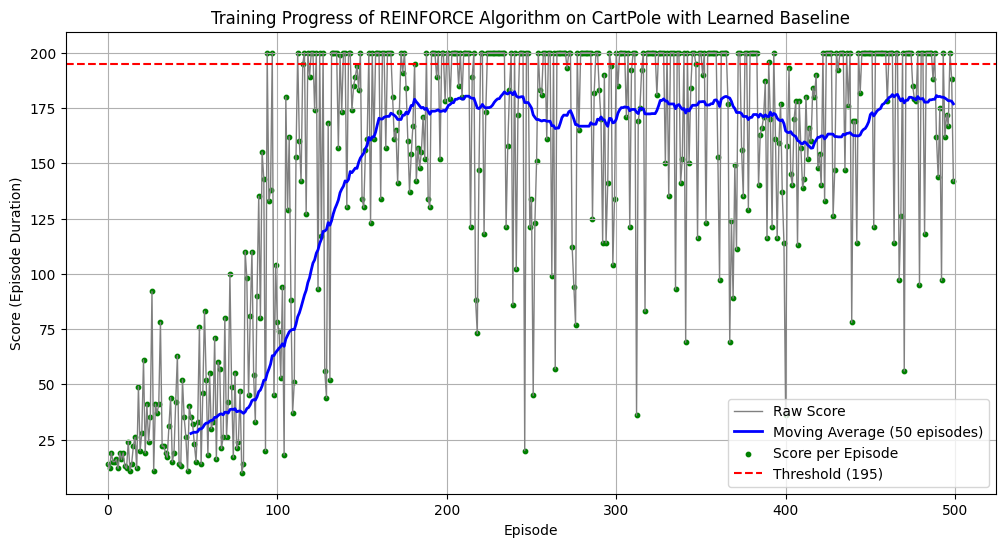

In [17]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        # We'll apply softmax in the forward pass to get probabilities

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)
        probs = torch.softmax(logits, dim=-1)
        return probs

# Define the value network
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        value = self.fc2(x)
        return value.squeeze()

# Instantiate the policy and value networks
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)
value_net = ValueNetwork(state_dim, hidden_size=128)

# Set the optimizers
learning_rate = 0.003
policy_optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)

# Learning rate schedulers
from torch.optim.lr_scheduler import StepLR
policy_scheduler = StepLR(policy_optimizer, step_size=50, gamma=0.9)
value_scheduler = StepLR(value_optimizer, step_size=50, gamma=0.9)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    # Reset the environment
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        state, _ = reset_result
    else:
        state = reset_result
    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []
    state_values = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Get state value from the value network
        value = value_net(state)
        # Step the environment
        step_result = env.step(action.item())
        if len(step_result) == 4:
            next_state, reward, done, _ = step_result
        else:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        next_state = torch.from_numpy(next_state).float()
        # Save reward, log probability, and state value
        rewards.append(reward)
        log_probs.append(log_prob)
        state_values.append(value)
        # Update state
        state = next_state
        if done:
            break

    # If no steps were taken, skip to next episode
    if not rewards:
        continue

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)
    # Convert state_values to tensor
    state_values = torch.stack(state_values).squeeze()
    # Compute advantages by subtracting the estimated state values
    advantages = returns - state_values.detach()
    # Normalize advantages for better convergence
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)
    # Compute policy gradient loss using advantages
    policy_loss = []
    for log_prob, advantage in zip(log_probs, advantages):
        policy_loss.append(-log_prob * advantage)
    policy_loss = torch.stack(policy_loss).sum()
    # Update policy network with gradient clipping
    policy_optimizer.zero_grad()
    policy_loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
    policy_optimizer.step()
    # Update policy scheduler
    policy_scheduler.step()
    # Compute value loss (MSE between estimated values and returns)
    value_loss = nn.functional.mse_loss(state_values, returns)
    # Update value network with gradient clipping
    value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_norm=1.0)
    value_optimizer.step()
    # Update value scheduler
    value_scheduler.step()
    # Log episode reward
    episode_rewards.append(sum(rewards))
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f'Episode {episode}\tAverage Reward: {avg_reward:.2f}')
    # Check for convergence
    if episode >= 100:
        avg_reward = np.mean(episode_rewards[-100:])
        if avg_reward >= 195.0:
            print(f'\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last 100 episodes.')
            break

# Close the environment
env.close()

# Plotting the rewards vs episodes
import matplotlib.pyplot as plt

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size)/window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
if len(score_array) >= window_size:
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of REINFORCE Algorithm on CartPole with Learned Baseline')
plt.legend()
plt.grid(True)
plt.show()
